In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost

     |████████████████████████████████| 67.4 MB 26 kB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dill

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

from catboost import CatBoostClassifier, Pool

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

Загрузам датасет и посмотрим на данные

In [4]:
df_train = pd.read_csv("/content/drive/MyDrive/train.csv")

In [5]:
df_valid = pd.read_csv("/content/drive/MyDrive/valid.csv")

In [6]:
df = pd.concat([df_train, df_valid], ignore_index=True) 

In [7]:
df.head(5)

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            60000 non-null  int64 
 1   Title         60000 non-null  object
 2   Body          60000 non-null  object
 3   Tags          60000 non-null  object
 4   CreationDate  60000 non-null  object
 5   Y             60000 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.7+ MB


Посмотрим на целевую переменную

In [9]:
df['Y'].value_counts()

HQ          20000
LQ_CLOSE    20000
LQ_EDIT     20000
Name: Y, dtype: int64

Мы имеем три класса. Дисбаланс классов отсутствует. Приоброзуем эту колонку




In [10]:
df_train.loc[df_train['Y'] == 'HQ', 'Y'] = 0
df_train.loc[df_train['Y'] == 'LQ_CLOSE', 'Y'] = 1
df_train.loc[df_train['Y'] == 'LQ_EDIT', 'Y'] = 2

In [11]:
df_train['Y'] = df_train['Y'].astype(int)

In [12]:
df_valid.loc[df_valid['Y'] == 'HQ', 'Y'] = 0
df_valid.loc[df_valid['Y'] == 'LQ_CLOSE', 'Y'] = 1
df_valid.loc[df_valid['Y'] == 'LQ_EDIT', 'Y'] = 2

In [13]:
df_valid['Y'] = df_valid['Y'].astype(int)

Создадим pipeline, в качестве модели используем catboost

In [14]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class TextImputer(BaseEstimator, TransformerMixin):
    def __init__(self, key, value):
        self.key = key
        self.value = value
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X[self.key] = X[self.key].fillna(self.value)
        return X

In [15]:

title = Pipeline([
                ('imputer', TextImputer('Title', '')),
                ('selector', ColumnSelector(key='Title')),
                ('tfidf', TfidfVectorizer())
            ])

body = Pipeline([
                ('imputer', TextImputer('Body', '')),
                ('selector', ColumnSelector(key='Body')),
                ('tfidf', TfidfVectorizer())
            ])

feats = FeatureUnion([('Title', title),
                      ('Body', body)])

In [16]:
X_train = df_train
y_train = df_train['Y']

In [17]:
X_test = df_valid
y_test = df_valid['Y']

In [18]:
features = ['Title', 'Body']
target = 'Y'

In [19]:
model_params = {
    'iterations': 250,
    "depth": 7, 
    'loss_function': 'MultiClass',
    'train_dir': 'crossentropy',
    'random_seed': 71,
    'silent': True,
}

In [20]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier',  CatBoostClassifier(**model_params)),
])

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Title',
                                                 Pipeline(memory=None,
                                                          steps=[('imputer',
                                                                  TextImputer(key='Title',
                                                                              value='')),
                                                                 ('selector',
                                                                  ColumnSelector(key='Title')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                           

In [21]:
predictions = pipeline.predict(X_test)

Для оценки модели применим метрику Accuracy, так как у нас есть 3 класса

In [22]:
print(f'Точность: {accuracy_score(predictions, y_test)*100:.2f}%')

Точность: 82.73%


Text(0.5, 1.0, 'Confusion Matrix')

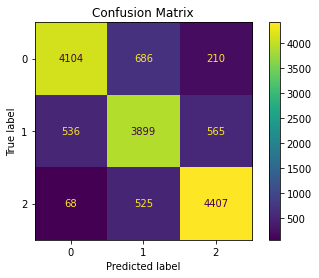

In [23]:
plot_confusion_matrix(pipeline, X_test, y_test, values_format='d')
plt.title(f"Confusion Matrix")

Из матрици видно что наихудшим классом для определения является LQ_CLOSE. Его меньшее количество истено положительных, а так с ним наибольшее сробатова как ложно-положительных так и ложно-отрицательных.

Сохраним нашу модель

In [24]:
with open("logreg_pipeline.dill", "wb") as f:
    dill.dump(pipeline, f)